# Question 4

Train GAN model and test with any data

## Import Libraries

In [1]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from matplotlib import pyplot as plt

Its always a good practice to check the current version of TensorFlow...

In [2]:
print(tf.version.VERSION)

2.6.2


## Prepare Fashion-MNIST data

- The Fashion MNIST dataset was created by e-commerce company, Zalando, as a drop-in replacement for MNIST Digits.
- Link : https://github.com/zalandoresearch/fashion-mnist

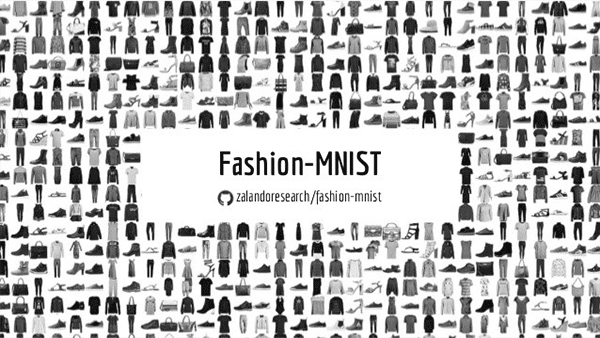

### Loading

In [3]:
# load the Fashion MNIST dataset and it's OK to use just the training data
(train_images, train_labels), (_, _) = tf.keras.datasets.fashion_mnist.load_data()

There are 60,000 training gray scale images in Fashion-MNIST.

In [4]:
train_images.shape

(60000, 28, 28)

In [5]:
type(train_images)

numpy.ndarray

### Visualization

I always like to visualize the training data to get an idea of what the images look like. 

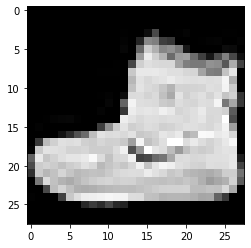

In [6]:
plt.figure()
plt.imshow(train_images[0], cmap='gray')
plt.show()

### Preprocessing

In [7]:
# Reshape data and also convert the data type to 'float32'
print(train_images.shape)
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
print(train_images.shape)

# scale from [0,255] to [-1,1]
train_images = (train_images - 127.5) / 127.5  

(60000, 28, 28)
(60000, 28, 28, 1)


## The generator model

Define the generator model architecture with the Keras `Sequential` API.

Use `ReLU` except for the last layer which has `tanh` as the activation.

The job of the generator is to make images, to do so in DCGAN, we feed random noise as input to the generator and upsample till the desired image size becomes 28x28x1.

In [8]:
# latent dimension of the random noise
LATENT_DIM = 100 
# weight initializer for G per DCGAN paper
WEIGHT_INIT = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02) 
# number of channels, 1 for gray scale and 3 for color images
CHANNELS = 1

In [9]:
def build_generator():
    # create a Keras Sequential model 
    model = Sequential(name="generator")

    # prepare for reshape: FC => BN => RN layers, note: input shape defined in the 1st Dense layer  
    model.add(layers.Dense(7 * 7 * 256, input_dim=LATENT_DIM))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    # 1D => 3D: reshape the output of the previous layer 
    model.add(layers.Reshape((7, 7, 256)))

    # upsample to 14x14: apply a transposed CONV => BN => RELU
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2),padding="same", kernel_initializer=WEIGHT_INIT))
    model.add(layers.BatchNormalization())
    model.add((layers.ReLU()))

    # upsample to 28x28: apply a transposed CONV => BN => RELU
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2),padding="same", kernel_initializer=WEIGHT_INIT))
    model.add(layers.BatchNormalization())
    model.add((layers.ReLU()))

    # final layer: Conv2D with tanh activation
    model.add(layers.Conv2D(CHANNELS, (5, 5), padding="same", activation="tanh"))

    # return the generator model
    return model

In [10]:
# build the generator model
generator = build_generator() 

In [11]:
generator.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12544)             1266944   
_________________________________________________________________
batch_normalization (BatchNo (None, 12544)             50176     
_________________________________________________________________
re_lu (ReLU)                 (None, 12544)             0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 128)       819328    
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 128)       512       
_________________________________________________________________
re_lu_1 (ReLU)               (None, 14, 14, 128)       0 

## The discriminator model

Define the discriminator model architecture with the Keras `Sequential` API

In [12]:
def build_discriminator(width, height, depth, alpha=0.2):
    # create a Keras Sequential model
    model = Sequential(name="discriminator")
    input_shape = (height, width, depth)

    # first set of CONV => BN => leaky ReLU layers
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding="same", 
        input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=alpha))

    # second set of CONV => BN => leacy ReLU layers
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=alpha))

    # flatten and apply dropout
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.3))

    # sigmoid in the last layer outputs a single value for binary classification
    model.add(layers.Dense(1, activation="sigmoid"))

    # return the discriminator model
    return model

In [13]:
# build the discriminator model
discriminator = build_discriminator(28, 28, 1) 

In [14]:
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
batch_normalization_3 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
batch_normalization_4 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)            

## Define `DCGAN` class: override `train_step`
Subclass `keras.Model` and override `train_step` to implement the DCGAN architecture. This is where the magic happens and the heart of the DCGAN implementation. 

**The discriminator loss** includes both the loss from the real images and the loss from the fake images.  
**The generator loss** is calculated with thefake images.


In [15]:
class DCGAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(DCGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):

        batch_size = tf.shape(real_images)[0]
        noise = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Step 1. Train the discriminator with both real images (label as 1) and fake images (classified as label as 0) 
        with tf.GradientTape() as tape:
            # Compute discriminator loss on real images
            pred_real = self.discriminator(real_images, training=True)
            d_loss_real = self.loss_fn(tf.ones((batch_size, 1)), pred_real)

            # Compute discriminator loss on fake images
            fake_images = self.generator(noise)
            pred_fake = self.discriminator(fake_images, training=True)
            d_loss_fake = self.loss_fn(tf.zeros((batch_size, 1)), pred_fake)

            # total discriminator loss
            d_loss = (d_loss_real + d_loss_fake)/2
        # Compute discriminator gradients
        grads = tape.gradient(d_loss, self.discriminator.trainable_variables)
        # Update discriminator weights
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_variables))

        # Step 2. Train the generator (do not update weights of the discriminator)
        # G wants D to think the fake images are real (label as 1)
        misleading_labels = tf.ones((batch_size, 1)) 

        with tf.GradientTape() as tape:
            fake_images = self.generator(noise, training=True)
            pred_fake = self.discriminator(fake_images, training=True)
            g_loss = self.loss_fn(misleading_labels, pred_fake)
        # Compute generator gradients
        grads = tape.gradient(g_loss, self.generator.trainable_variables)
        # Update generator weights
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_variables))

        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)

        return {"d_loss": self.d_loss_metric.result(), "g_loss": self.g_loss_metric.result()}

## Use Keras `Callback` to monitor training

The nice thing about overriding `train_step` of `keras.Model` is that we can subclass `Callback` to monitor our DCGAN training.

I use the seed noise to create images (with the generator model) throughout the training to visually inspect the progress of the generator. You can also save the generator model at the end of the training which could potentially be used for inference later.

In [16]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=100):
        self.num_img = num_img
        self.latent_dim = latent_dim

        # Create random noise seed for visualization during training
        self.seed = tf.random.normal([16, latent_dim])

    def on_epoch_end(self, epoch, logs=None):
        # random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        # generated_images = self.model.generator(random_latent_vectors)
        generated_images = self.model.generator(self.seed)
        # revert scaling
        generated_images = (generated_images * 127.5) + 127.5
        generated_images.numpy()

        fig = plt.figure(figsize=(4, 4))
        for i in range(self.num_img):
            plt.subplot(4, 4, i+1)
            img = keras.utils.array_to_img(generated_images[i]) 
            plt.imshow(img, cmap='gray')
            plt.axis('off')
        plt.savefig('epoch_{:03d}.png'.format(epoch)) 
        plt.show()

    def on_train_end(self, logs=None):
        self.model.generator.save('generator.h5')

## Train the DCGAN model

Compile the `dcgan` model, with the `Adam` optimizer, learning rate of 0.0002, and the **Binary Cross Entropy** loss functionas recommended by the paper. In future GAN tutorials, you will learn other loss functions for other GAN variants.

Putting together the `dcgan` model.

In [17]:
dcgan = DCGAN(discriminator=discriminator, generator=generator, latent_dim=LATENT_DIM)

Compile the `dcgan` model.

In [18]:
LR = 0.0002 # learning rate

dcgan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=LR, beta_1 = 0.5),
    g_optimizer=keras.optimizers.Adam(learning_rate=LR, beta_1 = 0.5),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

Now we simply call `model.fit()` to traing the `dcgan` model!

Epoch 1/50
1875/1875 [==============================] - 327s 174ms/step - d_loss: 0.2581 - g_loss: 1.0276


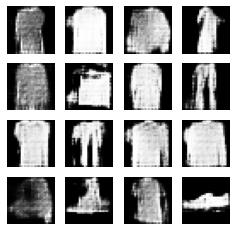

Epoch 2/50
1875/1875 [==============================] - 326s 174ms/step - d_loss: 0.6375 - g_loss: 0.9848


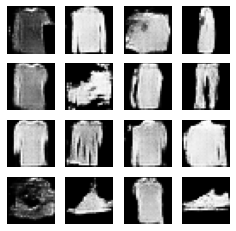

Epoch 3/50
1875/1875 [==============================] - 326s 174ms/step - d_loss: 0.6555 - g_loss: 0.9143


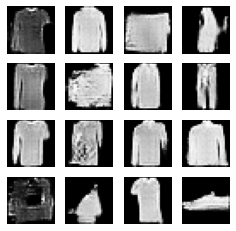

Epoch 4/50
1875/1875 [==============================] - 326s 174ms/step - d_loss: 0.6633 - g_loss: 0.8783


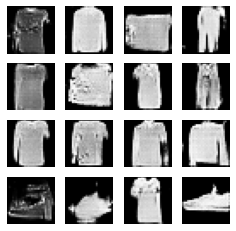

Epoch 5/50
1875/1875 [==============================] - 325s 173ms/step - d_loss: 0.6623 - g_loss: 0.8602


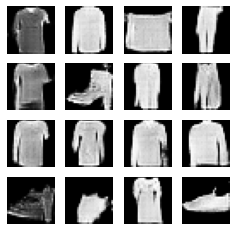

Epoch 6/50
1875/1875 [==============================] - 328s 175ms/step - d_loss: 0.6645 - g_loss: 0.8419


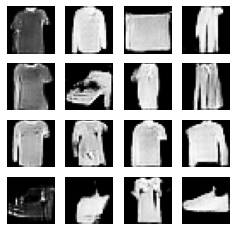

Epoch 7/50
1875/1875 [==============================] - 327s 174ms/step - d_loss: 0.6670 - g_loss: 0.8333


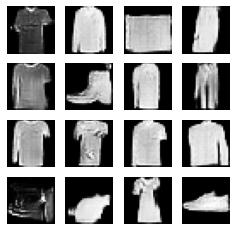

Epoch 8/50
1875/1875 [==============================] - 327s 174ms/step - d_loss: 0.6681 - g_loss: 0.8309


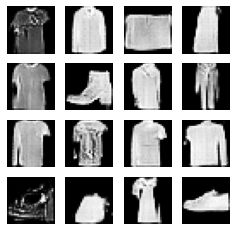

Epoch 9/50
1875/1875 [==============================] - 325s 174ms/step - d_loss: 0.6683 - g_loss: 0.8231


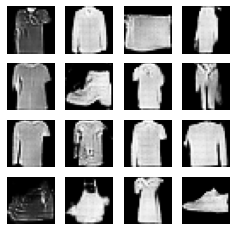

Epoch 10/50
1875/1875 [==============================] - 326s 174ms/step - d_loss: 0.6684 - g_loss: 0.8232


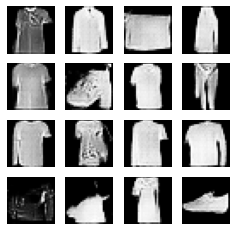

Epoch 11/50
1875/1875 [==============================] - 323s 173ms/step - d_loss: 0.6687 - g_loss: 0.8205


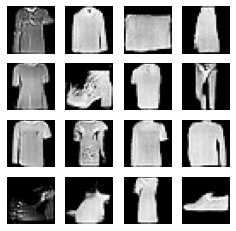

Epoch 12/50
1875/1875 [==============================] - 326s 174ms/step - d_loss: 0.6685 - g_loss: 0.8260


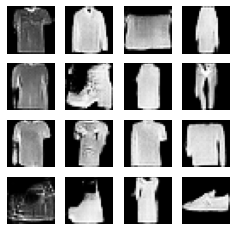

Epoch 13/50
1875/1875 [==============================] - 325s 174ms/step - d_loss: 0.6693 - g_loss: 0.8206


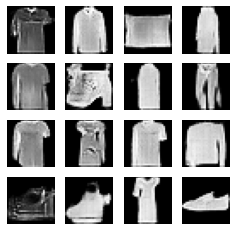

Epoch 14/50
1875/1875 [==============================] - 325s 173ms/step - d_loss: 0.6667 - g_loss: 0.8218


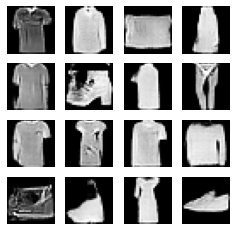

Epoch 15/50
1875/1875 [==============================] - 325s 173ms/step - d_loss: 0.6675 - g_loss: 0.8212


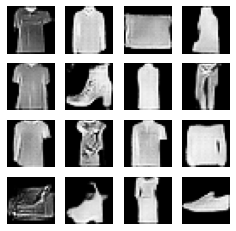

Epoch 16/50
1875/1875 [==============================] - 325s 173ms/step - d_loss: 0.6683 - g_loss: 0.8228


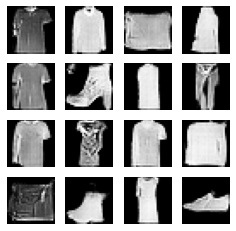

Epoch 17/50
1875/1875 [==============================] - 326s 174ms/step - d_loss: 0.6679 - g_loss: 0.8163


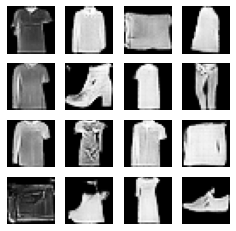

Epoch 18/50
1875/1875 [==============================] - 325s 173ms/step - d_loss: 0.6668 - g_loss: 0.8146


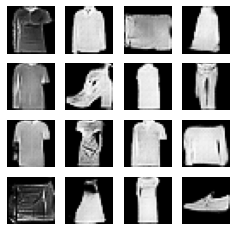

Epoch 19/50
1875/1875 [==============================] - 325s 174ms/step - d_loss: 0.6674 - g_loss: 0.8143


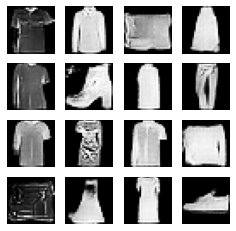

Epoch 20/50
1875/1875 [==============================] - 325s 173ms/step - d_loss: 0.6682 - g_loss: 0.8170


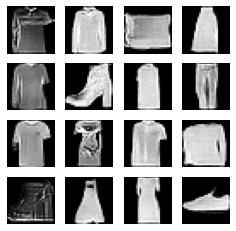

Epoch 21/50
1875/1875 [==============================] - 325s 173ms/step - d_loss: 0.6690 - g_loss: 0.8131


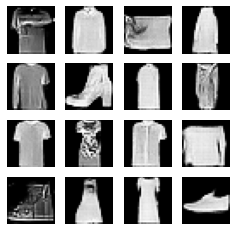

Epoch 22/50
1875/1875 [==============================] - 324s 173ms/step - d_loss: 0.6677 - g_loss: 0.8112


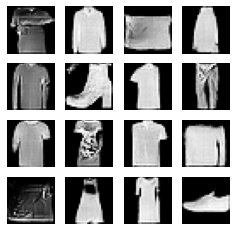

Epoch 23/50
1875/1875 [==============================] - 327s 174ms/step - d_loss: 0.6677 - g_loss: 0.8116


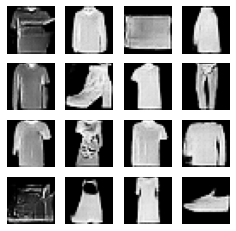

Epoch 24/50
1875/1875 [==============================] - 325s 173ms/step - d_loss: 0.6691 - g_loss: 0.8115


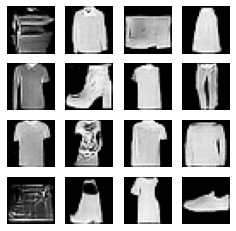

Epoch 25/50
1875/1875 [==============================] - 326s 174ms/step - d_loss: 0.6707 - g_loss: 0.8099


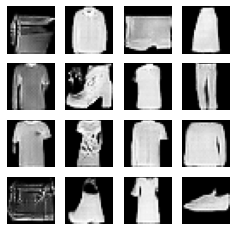

Epoch 26/50
1875/1875 [==============================] - 325s 173ms/step - d_loss: 0.6703 - g_loss: 0.8098


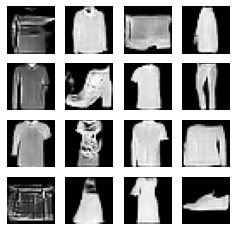

Epoch 27/50
1875/1875 [==============================] - 325s 173ms/step - d_loss: 0.6704 - g_loss: 0.8115


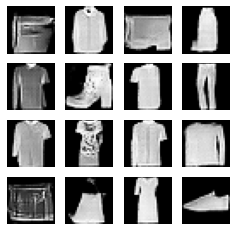

Epoch 28/50
1875/1875 [==============================] - 325s 174ms/step - d_loss: 0.6692 - g_loss: 0.8089


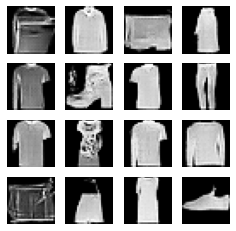

Epoch 29/50
1875/1875 [==============================] - 325s 173ms/step - d_loss: 0.6685 - g_loss: 0.8122


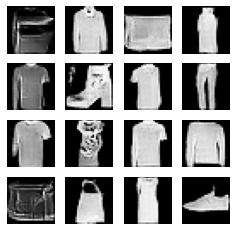

Epoch 30/50
1875/1875 [==============================] - 325s 173ms/step - d_loss: 0.6691 - g_loss: 0.8084


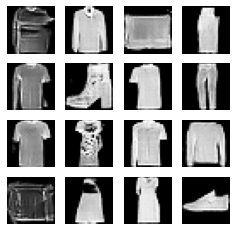

Epoch 31/50
1875/1875 [==============================] - 325s 174ms/step - d_loss: 0.6675 - g_loss: 0.8125


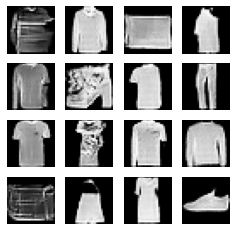

Epoch 32/50
1875/1875 [==============================] - 325s 174ms/step - d_loss: 0.6678 - g_loss: 0.8121


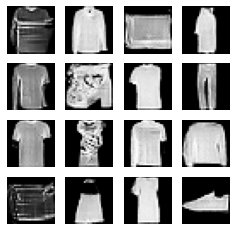

Epoch 33/50
1875/1875 [==============================] - 325s 173ms/step - d_loss: 0.6675 - g_loss: 0.8116


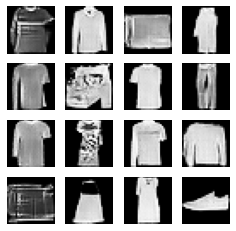

Epoch 34/50
1875/1875 [==============================] - 325s 173ms/step - d_loss: 0.6671 - g_loss: 0.8083


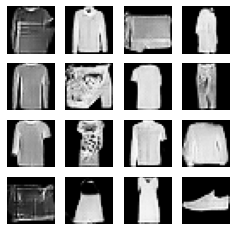

Epoch 35/50
1875/1875 [==============================] - 325s 173ms/step - d_loss: 0.6694 - g_loss: 0.8054


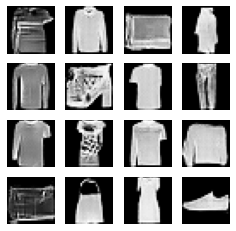

Epoch 36/50
1875/1875 [==============================] - 325s 173ms/step - d_loss: 0.6678 - g_loss: 0.8110


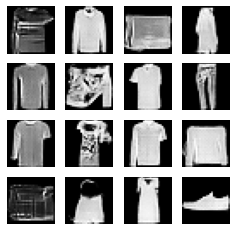

Epoch 37/50
1875/1875 [==============================] - 325s 173ms/step - d_loss: 0.6669 - g_loss: 0.8126


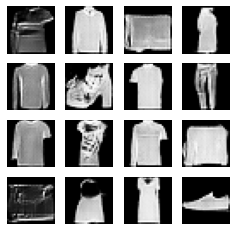

Epoch 38/50
1875/1875 [==============================] - 325s 173ms/step - d_loss: 0.6676 - g_loss: 0.8132


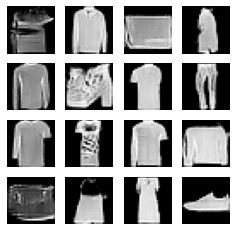

Epoch 39/50
1875/1875 [==============================] - 324s 173ms/step - d_loss: 0.6662 - g_loss: 0.8115


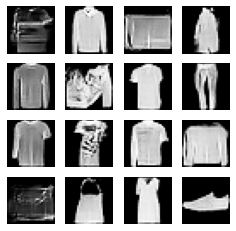

Epoch 40/50
1875/1875 [==============================] - 325s 174ms/step - d_loss: 0.6671 - g_loss: 0.8175


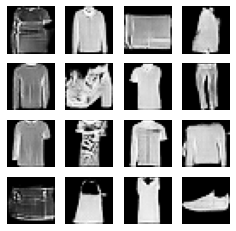

Epoch 41/50
1875/1875 [==============================] - 324s 173ms/step - d_loss: 0.6667 - g_loss: 0.8102


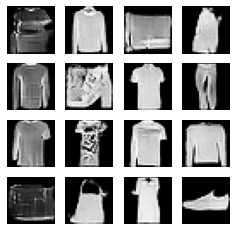

Epoch 42/50
1875/1875 [==============================] - 325s 173ms/step - d_loss: 0.6668 - g_loss: 0.8127


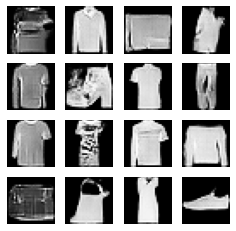

Epoch 43/50
1875/1875 [==============================] - 324s 173ms/step - d_loss: 0.6665 - g_loss: 0.8151


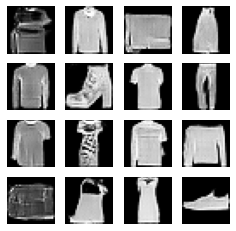

Epoch 44/50
1875/1875 [==============================] - 324s 173ms/step - d_loss: 0.6649 - g_loss: 0.8194


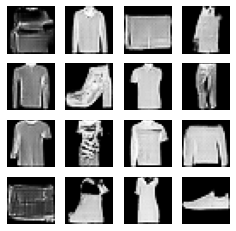

Epoch 45/50
1875/1875 [==============================] - 324s 173ms/step - d_loss: 0.6656 - g_loss: 0.8155


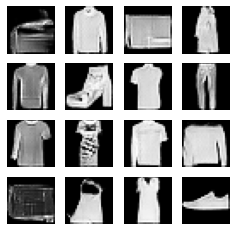

Epoch 46/50
1875/1875 [==============================] - 324s 173ms/step - d_loss: 0.6642 - g_loss: 0.8161


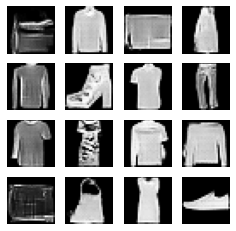

Epoch 47/50
1875/1875 [==============================] - 324s 173ms/step - d_loss: 0.6630 - g_loss: 0.8175


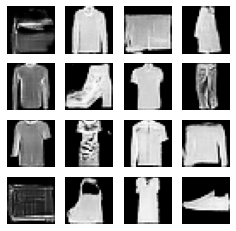

Epoch 48/50
1875/1875 [==============================] - 323s 173ms/step - d_loss: 0.6634 - g_loss: 0.8189


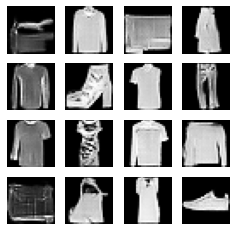

Epoch 49/50
1875/1875 [==============================] - 324s 173ms/step - d_loss: 0.6627 - g_loss: 0.8200


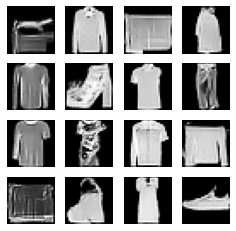

Epoch 50/50
1875/1875 [==============================] - 324s 173ms/step - d_loss: 0.6615 - g_loss: 0.8205


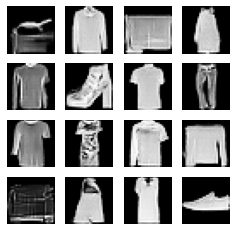

In [19]:
NUM_EPOCHS = 50 # number of epochs
dcgan.fit(train_images, epochs=NUM_EPOCHS, callbacks=[GANMonitor(num_img=16, latent_dim=LATENT_DIM)])